# Monte Carlo integration by Vegas

## Brute force Monte Carlo

First we will implement the simple Monte Carlo method.

In [1]:
# simple class to take care of statistically determined quantities
class Cumulants:
  def __init__(self):
    self.sum=0.0    # f_0 + f_1 +.... + f_N
    self.sqsum=0.0  # f_0^2 + f_1^2 +....+ f_N^2
    self.avg = 0.0  # I_best when many iterations, otherwise <f> = 1/N\sum_i f_i
    self.err = 0.0  # sigma of I_best when many iterations, otherwise sqrt( <f^2>-<f>^2 )/sqrt(N)
    self.chisq = 0.0
    self.weightsum=0.0 # \sum_i 1/sigma_i^2
    self.avgsum=0.0    # \sum_i <f>_i/sigma_i^2
    self.avg2sum=0.0   # \sum_i <f>_i^2/sigma_i^2

def SimpleMC(integrant, ndim, unit, maxeval, cum):
    nbatch=1000             # function will be evaluated in bacthes of 1000 evaluations at one time (for efficiency and storage issues)
    neval=0
    for nsamples in range(maxeval,0,-nbatch):  # loop over all_nsample evaluations in batches of nbatch
        n = min(nbatch,nsamples)  # How many evaluations in this pass?
        xr = unit*random.random((n,ndim)) # generates 2-d array of random numbers in the interval [0,1)
        wfun = integrant(xr)  # n function evaluations required in single call
        neval += n  # We just added so many fuction evaluations
        cum.sum += sum(wfun)      # sum_i f_i*w_i = <fw>
        cum.sqsum += sum(wfun*wfun)    # sum_i (f_i*w_i)^2 = <fw^2>/all_nsamples
    
    cum.avg = cum.sum/neval
    w0 = sqrt(cum.sqsum/neval)  # sqrt(<f^2>)
    cum.err = sqrt((w0-cum.avg)*(w0+cum.avg)/neval) # sqrt(sqsum-sum**2)
    cum.avg *= unit**ndim  # adding units if not [0,1] interval
    cum.err *= unit**ndim  # adding units if not [0,1] interval

We used here a simple trick to avoid overflow, i.e.,

\begin{eqnarray}
\sqrt{\frac{\langle f^2\rangle-\langle f\rangle^2}{N}} = 
\sqrt{\frac{(\sqrt{\langle f^2\rangle}-\langle f\rangle)(\sqrt{\langle f^2\rangle}+\langle f\rangle)}{N}}
\end{eqnarray}

In [2]:
def my_integrant2(x):
    """ For testing, we are integration the function
       1/(1-cos(x)*cos(y)*cos(z))/pi^3
       in the interval [0,pi]**3
    """
    #nbatch,ndim = shape(x)
    return 1.0/(1.0-cos(x[:,0])*cos(x[:,1])*cos(x[:,2]))/pi**3

In [5]:
from scipy import *
from numpy import *
unit=pi
ndim=3
maxeval=200000
exact = 1.3932  # exact value of the integral
    
cum = Cumulants()
    
SimpleMC(my_integrant2, ndim, pi, maxeval, cum)
print(cum.avg, '+-', cum.err, 'exact=', exact)
print('how many sigma away', abs(cum.avg-exact)/cum.err)

1.3708722833046845 +- 0.015351159564106933 exact= 1.3932
how many sigma away 1.454464504917317


## Vegas

First we define the grid points $g(x)$. At the beginning, we just set $g(x)=x$.

In [6]:
class Grid:
    """Contains the grid points g_n(x) with x=[0...1], and g=[0...1]
       for Vegas integration. There are n-dim g_n functions.
       Constraints : g(0)=0 and g(1)=1.
    """
    def __init__(self, ndim, nbins):
        self.g = zeros((ndim,nbins+1))  
        # a bit dirty trick: We will later use also g[-1] in interpolation, which should be set to zero, hence
        # we allocate dimension nbins+1, rather than nbinx
        self.ndim=ndim
        self.nbins=nbins
        # At the beginning we set g(x)=x
        # The grid-points are x_0 = 1/N, x_1 = 2/N, ... x_{N-1}=1.0. 
        # Note that g(0)=0, and we skip this point on the mesh.
        for idim in range(ndim):
            self.g[idim,:nbins] = arange(1,nbins+1)/float(nbins)

In [8]:
def Vegas_step1(integrant, unit, maxeval, nstart, nincrease, grid, cum):
    ndim, nbins = grid.ndim,grid.nbins  # dimension of the integral, size of the grid for binning in each direction
    unit_dim = unit**ndim   # converts from unit cube integration to generalized cube with unit length
    nbatch=1000             # function will be evaluated in bacthes of 1000 evaluations at one time (for efficiency and storage issues)
    neval=0
    print ("""Vegas parameters:
       ndim = """+str(ndim)+"""
       unit = """+str(unit)+"""
       maxeval = """+str(maxeval)+"""
       nstart = """+str(nstart)+"""
       nincrease = """+str(nincrease)+"""
       nbins = """+str(nbins)+"""
       nbaths = """+str(nbatch)+"\n")

    bins = zeros((nbatch,ndim),dtype=int) # in which sampled bin does this point fall?
    
    
    all_nsamples = nstart
    for nsamples in range(all_nsamples,0,-nbatch):  # loop over all_nsample evaluations in batches of nbatch
        n = min(nbatch,nsamples)  # How many evaluations in this pass?
        # We are integrating f(g_1(x),g_2(y),g_3(z))*dg_1/dx*dg_2/dy*dg_3/dz dx*dy*dz
        # This is represented as  1/all_nsamples \sum_{x_i,y_i,z_i} f(g_1(x_i),g_2(y_i),g_3(z_i))*dg_1/dx*dg_2/dy*dg_3/dz
        #  where dg_1/dx = diff*NBINS
        wgh = zeros(nbatch)          # weights for each random point in the batch
        xr = random.random((n,ndim)) # generates 2-d array of random numbers in the interval [0,1)
        for i in range(n):
            weight = 1.0/all_nsamples
            for dim in range(ndim):
                # We want to evaluate the function f at point g(x), i.e, f(g_1(x),g_2(y),...)
                # Here we transform the points x,y,z -> g_1(x), g_2(y), g_3(z)
                # We hence want to evaluate g(x) ~ g(x[i]), where x is the random number and g is the grid function
                # The discretized g(t) is defined on the grid :
                #       t[-1]=0, t[0]=1/N, t[1]=2/N, t[2]=3/N ... t[N-1]=1.
                # We know that g(0)=0 and g(1)=1, so that g[-1]=0.0 and g[N-1]=1.0
                # To interpolate g at x, we first compute  i=int(x*N) and then we use linear interpolation
                # g(x) = g[i-1] + (g[i]-g[i-1])*(x*N-i)  ;  if i>0
                # g(x) =   0    + (g[0]-0)*(x*N-0)       ;  if i=0
                #
                pos = xr[i,dim]*nbins               # which grid would it fit ? (x*N)
                ipos = int(pos)                     # the grid position is ipos : int(x*N)==i    
                diff = grid.g[dim,ipos] - grid.g[dim,ipos-1]  # g[i]-g[i-1]
                # linear interpolation for g(x) : 
                xr[i,dim] = (grid.g[dim,ipos-1] + (pos-ipos)*diff)*unit # g(xr) ~ ( g[i-1]+(g[i]-g[i-1])*(x*N-i) )*[units]
                bins[i,dim]=ipos                    # remember in which bin this random number falls.
                weight *= diff*nbins                #  weight for this dimension is dg/dx = (g[i]-g[i-1])*N
                                                    # because dx = i/N - (i-1)/N = 1/N
            wgh[i] = weight # total weight is  (df/dx)*(df/dy)*(df/dx).../N_{samples}
        # Here we evaluate function f on all randomly generated x points above
        fx = integrant(xr)  # n function evaluations required in single call
        neval += n  # We just added so many fuction evaluations

        # Now we compute the integral as weighted average, namely, f(g(x))*dg/dx
        wfun = wgh * fx           # weight * function ~ f_i*w_i
        cum.sum += sum(wfun)      # sum_i f_i*w_i = <fw>
        wfun *= wfun              # carefull : this is like  (f_i * w_i/N)^2 hence  1/N (1/N (f_i*w_i)^2)
        cum.sqsum += sum(wfun)    # sum_i (f_i*w_i)^2 = <fw^2>/all_nsamples
                                  # 
    w0 = sqrt(cum.sqsum*all_nsamples)  # w0 = sqrt(<fw^2>)
    w1 = (w0 + cum.sum)*(w0 - cum.sum) # w1 = (w0^2 - <fw>^2) = (<fw^2>-<fw>^2)
    w = (all_nsamples-1)/w1            # w ~ 1/sigma_i^2 = (N-1)/(<fw^2>-<fw>^2)
    # Note that variance of the MC sampling is Var(monte-f) = (<f^2>-<f>^2)/N == 1/sigma_i^2
    cum.weightsum += w          # weightsum ~ \sum_i 1/sigma_i^2
    cum.avgsum += w*cum.sum     # avgsum    ~ \sum_i <fw>_i / sigma_i^2
    
    cum.avg = cum.avgsum/cum.weightsum     # I_best = (\sum_i <fw>_i/sigma_i^2 )/(\sum_i 1/sigma_i^2)
    cum.err = sqrt(1/cum.weightsum)        # err ~ sqrt(best sigma^2) = sqrt(1/(\sum_i 1/sigma_i^2))
     
    cum.avg *= unit**ndim
    cum.err *= unit**ndim

In [10]:
from scipy import *
from numpy import *

unit=pi
ndim=3
maxeval=200000
exact = 1.3932  # exact value of the integral
    
cum = Cumulants()
    
nbins=128
nstart =10000
nincrease=5000
grid = Grid(ndim,nbins)
random.seed(0)

#SimpleMC(my_integrant2, ndim, pi, maxeval, cum)
Vegas_step1(my_integrant2, pi, maxeval, nstart, nincrease, grid, cum)
print (cum.avg, '+-', cum.err, 'exact=', exact)

Vegas parameters:
       ndim = 3
       unit = 3.141592653589793
       maxeval = 200000
       nstart = 10000
       nincrease = 5000
       nbins = 128
       nbaths = 1000

1.3258378290394897 +- 0.02037303730823348 exact= 1.3932


In [11]:
def Vegas_step2(integrant, unit, maxeval, nstart, nincrease, grid, cum):
    ndim, nbins = grid.ndim,grid.nbins  # dimension of the integral, size of the grid for binning in each direction
    unit_dim = unit**ndim   # converts from unit cube integration to generalized cube with unit length
    nbatch=1000             # function will be evaluated in bacthes of 1000 evaluations at one time (for efficiency and storage issues)
    neval=0
    print ("""Vegas parameters:
       ndim = """+str(ndim)+"""
       unit = """+str(unit)+"""
       maxeval = """+str(maxeval)+"""
       nstart = """+str(nstart)+"""
       nincrease = """+str(nincrease)+"""
       nbins = """+str(nbins)+"""
       nbaths = """+str(nbatch)+"\n")

    bins = zeros((nbatch,ndim),dtype=int) # in which sampled bin does this point fall?
    
    
    all_nsamples = nstart
    fxbin = zeros((ndim,nbins))    #new2: after each iteration we reset the average function being binned
    for nsamples in range(all_nsamples,0,-nbatch):  # loop over all_nsample evaluations in batches of nbatch
        n = min(nbatch,nsamples)  # How many evaluations in this pass?
        # We are integrating f(g_1(x),g_2(y),g_3(z))*dg_1/dx*dg_2/dy*dg_3/dz dx*dy*dz
        # This is represented as  1/all_nsamples \sum_{x_i,y_i,z_i} f(g_1(x_i),g_2(y_i),g_3(z_i))*dg_1/dx*dg_2/dy*dg_3/dz
        #  where dg_1/dx = diff*NBINS
        wgh = zeros(nbatch)          # weights for each random point in the batch
        xr = random.random((n,ndim)) # generates 2-d array of random numbers in the interval [0,1)
        for i in range(n):
            weight = 1.0/all_nsamples
            for dim in range(ndim):
                # We want to evaluate the function f at point g(x), i.e, f(g_1(x),g_2(y),...)
                # Here we transform the points x,y,z -> g_1(x), g_2(y), g_3(z)
                # We hence want to evaluate g(x) ~ g(x[i]), where x is the random number and g is the grid function
                # The discretized g(t) is defined on the grid :
                #       t[-1]=0, t[0]=1/N, t[1]=2/N, t[2]=3/N ... t[N-1]=1.
                # We know that g(0)=0 and g(1)=1, so that g[-1]=0.0 and g[N-1]=1.0
                # To interpolate g at x, we first compute  i=int(x*N) and then we use linear interpolation
                # g(x) = g[i-1] + (g[i]-g[i-1])*(x*N-i)  ;  if i>0
                # g(x) =   0    + (g[0]-0)*(x*N-0)       ;  if i=0
                #
                pos = xr[i,dim]*nbins               # which grid would it fit ? (x*N)
                ipos = int(pos)                     # the grid position is ipos : int(x*N)==i
                diff = grid.g[dim,ipos] - grid.g[dim,ipos-1]  # g[i]-g[-1]
                # linear interpolation for g(x) : 
                xr[i,dim] = (grid.g[dim,ipos-1] + (pos-ipos)*diff)*unit # g(xr) ~ ( g[i-1]+(g[i]-g[i-1])*(x*N-i) )*[units]
                bins[i,dim]=ipos                    # remember in which bin this random number falls.
                weight *= diff*nbins                #  weight for this dimension is dg/dx = (g[i]-g[i-1])*N
                                                    # because dx = i/N - (i-1)/N = 1/N
            wgh[i] = weight # total weight is  (df/dx)*(df/dy)*(df/dx).../N_{samples}
        # Here we evaluate function f on all randomly generated x points above
        fx = integrant(xr)  # n function evaluations required in single call
        neval += n  # We just added so many fuction evaluations

        # Now we compute the integral as weighted average, namely, f(g(x))*dg/dx
        wfun = wgh * fx           # weight * function ~ f_i*w_i
        cum.sum += sum(wfun)      # sum_i f_i*w_i = <fw>
        wfun *= wfun              # carefull : this is like  (f_i * w_i/N)^2 hence  1/N (1/N (f_i*w_i)^2)
        cum.sqsum += sum(wfun)    # sum_i (f_i*w_i)^2 = <fw^2>/all_nsamples
                                  # 
        for dim in range(ndim):   #new2
            # projection of the sampled function^2 to each dimension, which will be used to improve the grid.
            for i in range(n):    #new2
                fxbin[dim, bins[i,dim] ] += wfun[i] #new2: just bin the function f. We saved the bin position before.
            
    w0 = sqrt(cum.sqsum*all_nsamples)  # w0 = sqrt(<fw^2>)
    w1 = (w0 + cum.sum)*(w0 - cum.sum) # w1 = (w0^2 - <fw>^2) = (<fw^2>-<fw>^2)
    w = (all_nsamples-1)/w1            # w ~ 1/sigma_i^2 = (N-1)/(<fw^2>-<fw>^2)
    # Note that variance of the MC sampling is Var(monte-f) = (<f^2>-<f>^2)/N == 1/sigma_i^2
    cum.weightsum += w          # weightsum ~ \sum_i 1/sigma_i^2
    cum.avgsum += w*cum.sum     # avgsum    ~ \sum_i <fw>_i / sigma_i^2
    
    cum.avg = cum.avgsum/cum.weightsum     # I_best = (\sum_i <fw>_i/sigma_i^2 )/(\sum_i 1/sigma_i^2)
    cum.err = sqrt(1/cum.weightsum)        # err ~ sqrt(best sigma^2) = sqrt(1/(\sum_i 1/sigma_i^2))
     
    cum.avg *= unit**ndim
    cum.err *= unit**ndim
    
    return fxbin

In [13]:
from scipy import *
from numpy import *

unit=pi
ndim=3
maxeval=200000
exact = 1.3932  # exact value of the integral
    
cum = Cumulants()
    
nbins=128
nstart =10000
nincrease=5000
grid = Grid(ndim,nbins)

#SimpleMC(my_integrant2, ndim, pi, maxeval, cum)
fxbin = Vegas_step2(my_integrant2, pi, maxeval, nstart, nincrease, grid, cum)
print(cum.avg, '+-', cum.err, 'exact=', exact)

Vegas parameters:
       ndim = 3
       unit = 3.141592653589793
       maxeval = 200000
       nstart = 10000
       nincrease = 5000
       nbins = 128
       nbaths = 1000

1.3309249724420185 +- 0.024495231851185392 exact= 1.3932


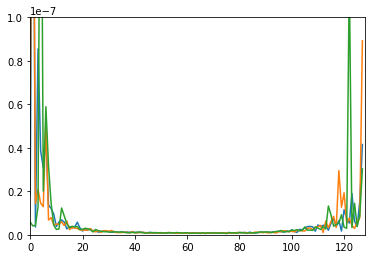

In [14]:
from pylab import *
%matplotlib inline

plot(fxbin[0])
plot(fxbin[1])
plot(fxbin[2])
xlim([0,128])
ylim([0,1e-7])
show()

In [16]:
def smfun(x):
    if (x>0):
        return ((x-1.)/log(x))**(1.5)
    else:
        return 0.
vsmfun = vectorize(smfun)

def Smoothen(fxbin):
    (ndim,nbins) = shape(fxbin)
    final = zeros(shape(fxbin))
    for idim in range(ndim):
        fxb = copy(fxbin[idim,:])
        #**** smooth the f^2 value stored for each bin ****
        # f[i] <- (f[i+1]+f[i]+f[i-1])/3.
        fxb[:nbins-1] += fxbin[idim,1:nbins]
        fxb[1:nbins]  += fxbin[idim,:nbins-1]
        fxb[1:nbins-1] *= 1/3.
        fxb[0] *= 1/2.
        fxb[nbins-1] *= 1/2.
        norm = sum(fxb)
        if( norm == 0 ):
            print ('ERROR can not refine the grid with zero grid function')
            return # can not refine the grid if the function is zero.
        fxb *= 1.0/norm         # we normalize the function.
        # Note that normalization is such that the sum is 1.
        final[idim,:] = vsmfun(fxb)
    return final

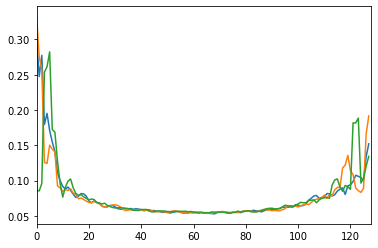

In [17]:
from pylab import *
%matplotlib inline

imp = Smoothen(fxbin)

plot(imp[0])
plot(imp[1])
plot(imp[2])
xlim([0,128])
show()

In [18]:
class Grid:
    """Contains the grid points g_n(x) with x=[0...1], and g=[0...1]
       for Vegas integration. There are n-dim g_n functions.
       Constraints : g(0)=0 and g(1)=1.
    """
    def __init__(self, ndim, nbins):
        self.g = zeros((ndim,nbins+1))  
        # a bit dirty trick: We will later use also g[-1] in interpolation, which should be set to zero, hence
        # we allocate dimension nbins+1, rather than nbinx
        self.ndim=ndim
        self.nbins=nbins
        # At the beginning we set g(x)=x
        # The grid-points are x_0 = 1/N, x_1 = 2/N, ... x_{N-1}=1.0. 
        # Note that g(0)=0, and we skip this point on the mesh.
        for idim in range(ndim):
            self.g[idim,:nbins] = arange(1,nbins+1)/float(nbins)
            
    def RefineGrid(self, imp):
        (ndim,nbins) = shape(imp)
        gnew = zeros((ndim,nbins+1))
        for idim in range(ndim):
            avgperbin = sum(imp[idim,:])/nbins
            #**** redefine the size of each bin  ****
            newgrid = zeros(nbins)
            cur=0.0
            newcur=0.0
            thisbin = 0.0
            ibin = -1
            # we are trying to determine
            #   Int[ f(g) dg, {g, g_{i-1},g_i}] == I/N_g
            #   where I == avgperbin
            for newbin in range(nbins-1):  # all but the last bin, which is 1.0
                while (thisbin < avgperbin) :
                    ibin+=1
                    thisbin += imp[idim,ibin]
                    prev = cur
                    cur = self.g[idim,ibin]
                # Explanation is in order : 
                #   prev    -- g^{old}_{l-1}
                #   cur     -- g^{old}_l
                #   thisbin -- Sm = f_{l-k}+.... +f_{l-2}+f_{l-1}+f_l
                #   we know that  Sm is just a bit more than we need, i.e., I/N_g, hence we need to compute how much more
                #   using linear interpolation :
                #   g^{new} = g_l - (g_l-g_{l-1}) * (f_{l-k}+....+f_{l-2}+f_{l-1}+f_l - I/N_g)/f_l
                #    clearly
                #         if I/N_g == f_{l-k}+....+f_{l-2}+f_{l-1}+f_l
                #            we will get g^{new} = g_l
                #     and if I/N_g == f_{l-k}+....+f_{l-2}+f_{l-1}
                #            we will get g^{new} = g_{l-1}
                #     and if I/N_g  is between the two possibilities, we will get linear interpolation between
                #     g_{l-1} and g_l
                #     
                thisbin -= avgperbin   # thisbin <- (f_{l-k}+....+f_{l-2}+f_{l-1}+f_l - I/N_g)
                delta = (cur - prev)*thisbin # delta <-  (g_l-g_{l-1})*(f_{l-k}+....+f_{l-2}+f_{l-1}+f_l - I/N_g)
                # cur is the closest point from the old mesh, while delta/imp is the correction using linear interpolation.
                newgrid[newbin] = cur - delta/imp[idim,ibin]  

            newgrid[nbins-1]=1.0
            gnew[idim,:nbins]= newgrid
        self.g = gnew
        return gnew

Update the class Grid, so that it can refine the grid

Vegas parameters:
       ndim = 3
       unit = 3.141592653589793
       maxeval = 200000
       nstart = 10000
       nincrease = 5000
       nbins = 128
       nbaths = 1000

1.3566487320143834 +- 0.03253120196392669 exact= 1.3932


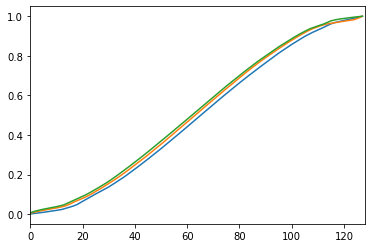

In [22]:
from scipy import *
from numpy import *

unit=pi
ndim=3
maxeval=200000
exact = 1.3932  # exact value of the integral
    
cum = Cumulants()
    
nbins=128
nstart =10000
nincrease=5000

grid = Grid(ndim,nbins)

fxbin = Vegas_step2(my_integrant2, pi, maxeval, nstart, nincrease, grid, cum)
imp = Smoothen(fxbin)
grid.RefineGrid(imp)
print(cum.avg, '+-', cum.err, 'exact=', exact)

plot(grid.g[0,:nbins])
plot(grid.g[1,:nbins])
plot(grid.g[2,:nbins])
xlim([0,128])
show()

In [23]:
def Vegas_step3(integrant, unit, maxeval, nstart, nincrease, grid, cum):
    ndim, nbins = grid.ndim,grid.nbins  # dimension of the integral, size of the grid for binning in each direction
    unit_dim = unit**ndim   # converts from unit cube integration to generalized cube with unit length
    nbatch=1000             # function will be evaluated in bacthes of 1000 evaluations at one time (for efficiency and storage issues)
    neval=0
    print ("""Vegas parameters:
       ndim = """+str(ndim)+"""
       unit = """+str(unit)+"""
       maxeval = """+str(maxeval)+"""
       nstart = """+str(nstart)+"""
       nincrease = """+str(nincrease)+"""
       nbins = """+str(nbins)+"""
       nbaths = """+str(nbatch)+"\n")

    bins = zeros((nbatch,ndim),dtype=int) # in which sampled bin does this point fall?
    
    
    all_nsamples = nstart
    for iter in range(1000):
        wgh = zeros(nbatch)            # weights for each random point in the batch
        fxbin = zeros((ndim,nbins))    # after each iteration we reset the average function being binned
        for nsamples in range(all_nsamples,0,-nbatch):  # loop over all_nsample evaluations in batches of nbatch
            n = min(nbatch,nsamples)  # How many evaluations in this pass?
            # We are integrating f(g_1(x),g_2(y),g_3(z))*dg_1/dx*dg_2/dy*dg_3/dz dx*dy*dz
            # This is represented as  1/all_nsamples \sum_{x_i,y_i,z_i} f(g_1(x_i),g_2(y_i),g_3(z_i))*dg_1/dx*dg_2/dy*dg_3/dz
            #  where dg_1/dx = diff*NBINS
            xr = random.random((n,ndim)) # generates 2-d array of random numbers in the interval [0,1)
            for i in range(n):
                weight = 1.0/all_nsamples
                for dim in range(ndim):
                    # We want to evaluate the function f at point g(x), i.e, f(g_1(x),g_2(y),...)
                    # Here we transform the points x,y,z -> g_1(x), g_2(y), g_3(z)
                    # We hence want to evaluate g(x) ~ g(x[i]), where x is the random number and g is the grid function
                    # The discretized g(t) is defined on the grid :
                    #       t[-1]=0, t[0]=1/N, t[1]=2/N, t[2]=3/N ... t[N-1]=1.
                    # We know that g(0)=0 and g(1)=1, so that g[-1]=0.0 and g[N-1]=1.0
                    # To interpolate g at x, we first compute  i=int(x*N) and then we use linear interpolation
                    # g(x) = g[i-1] + (g[i]-g[i-1])*(x*N-i)  ;  if i>0
                    # g(x) =   0    + (g[0]-0)*(x*N-0)       ;  if i=0
                    #
                    pos = xr[i,dim]*nbins               # which grid would it fit ? (x*N)
                    ipos = int(pos)                     # the grid position is ipos : int(x*N)==i
                    diff = grid.g[dim,ipos] - grid.g[dim,ipos-1]  # g[i]-g[-1]
                    # linear interpolation for g(x) : 
                    xr[i,dim] = (grid.g[dim,ipos-1] + (pos-ipos)*diff)*unit # g(xr) ~ ( g[i-1]+(g[i]-g[i-1])*(x*N-i) )*[units]
                    bins[i,dim]=ipos                    # remember in which bin this random number falls.
                    weight *= diff*nbins                #  weight for this dimension is dg/dx = (g[i]-g[i-1])*N
                                                        # because dx = i/N - (i-1)/N = 1/N
                wgh[i] = weight # total weight is  (df/dx)*(df/dy)*(df/dx).../N_{samples}
            
            # Here we evaluate function f on all randomly generated x points above
            fx = integrant(xr)  # n function evaluations required in single call
            neval += n  # We just added so many fuction evaluations

            # Now we compute the integral as weighted average, namely, f(g(x))*dg/dx
            wfun = wgh * fx           # weight * function ~ f_i*w_i            
            cum.sum += sum(wfun)      # sum_i f_i*w_i = <fw>
            wfun *= wfun              # carefull : this is like  (f_i * w_i/N)^2 hence  1/N (1/N (f_i*w_i)^2)
            cum.sqsum += sum(wfun)    # sum_i (f_i*w_i)^2 = <fw^2>/all_nsamples
                                      # 
            for dim in range(ndim):   #new2
                # Here we make a better approximation for the function, which we are integrating.
                for i in range(n):    #new2
                    fxbin[dim, bins[i,dim] ] += wfun[i] #new2: just bin the function f. We saved the bin position before.

        w0 = sqrt(cum.sqsum*all_nsamples)  # w0 = sqrt(<fw^2>)
        w1 = (w0 + cum.sum)*(w0 - cum.sum) # w1 = (w0^2 - <fw>^2) = (<fw^2>-<fw>^2)
        w = (all_nsamples-1)/w1            # w ~ 1/sigma_i^2 = (N-1)/(<fw^2>-<fw>^2)
        # Note that variance of the MC sampling is Var(monte-f) = (<f^2>-<f>^2)/N == 1/sigma_i^2
        cum.weightsum += w          # weightsum ~ \sum_i 1/sigma_i^2
        cum.avgsum += w*cum.sum     # avgsum    ~ \sum_i <fw>_i / sigma_i^2
        cum.avg2sum += w*cum.sum**2  # avg2cum   ~ \sum_i <fw>_i^2/sigma_i^2
        
        cum.avg = cum.avgsum/cum.weightsum     # I_best = (\sum_i <fw>_i/sigma_i^2 )/(\sum_i 1/sigma_i^2)
        cum.err = sqrt(1/cum.weightsum)        # err ~ sqrt(best sigma^2) = sqrt(1/(\sum_i 1/sigma_i^2))
     
        # new in this step
        if iter>0:
            cum.chisq = (cum.avg2sum - 2*cum.avgsum*cum.avg + cum.weightsum*cum.avg**2)/iter
    
        print ("Iteration {:3d}: I= {:10.8f} +- {:10.8f}  chisq= {:10.8f} number of evaluations = {:7d} ".format(iter+1, cum.avg*unit_dim, cum.err*unit_dim, cum.chisq, neval))
        imp = Smoothen(fxbin)
        grid.RefineGrid(imp)
        
        cum.sum=0                    # clear the partial sum for the next step
        cum.sqsum=0
        all_nsamples += nincrease    # for the next time, increase the number of steps a bit
        if (neval>=maxeval): break
        
    cum.avg *= unit**ndim
    cum.err *= unit**ndim

Vegas parameters:
       ndim = 3
       unit = 3.141592653589793
       maxeval = 2000000
       nstart = 100000
       nincrease = 5000
       nbins = 128
       nbaths = 1000

Iteration   1: I= 1.36762346 +- 0.01023309  chisq= 0.00000000 number of evaluations =  100000 
Iteration   2: I= 1.38308994 +- 0.00488295  chisq= 2.95787653 number of evaluations =  205000 
Iteration   3: I= 1.38903765 +- 0.00341085  chisq= 2.92764168 number of evaluations =  315000 
Iteration   4: I= 1.39085420 +- 0.00271957  chisq= 2.21131183 number of evaluations =  430000 
Iteration   5: I= 1.39235286 +- 0.00238578  chisq= 1.98798517 number of evaluations =  550000 
Iteration   6: I= 1.39215278 +- 0.00209328  chisq= 1.59649946 number of evaluations =  675000 
Iteration   7: I= 1.39187814 +- 0.00186075  chisq= 1.34408861 number of evaluations =  805000 
Iteration   8: I= 1.39040546 +- 0.00167503  chisq= 1.62389166 number of evaluations =  940000 
Iteration   9: I= 1.39098400 +- 0.00155755  chisq= 1.53107506

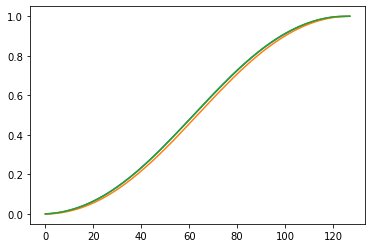

In [25]:
from scipy import *
from numpy import *

unit=pi
ndim=3
maxeval=2000000
exact = 1.3932  # exact value of the integral
    
cum = Cumulants()
    
nbins=128
nstart =100000
nincrease=5000

grid = Grid(ndim,nbins)

random.seed(0)

Vegas_step3(my_integrant2, pi, maxeval, nstart, nincrease, grid, cum)

print (cum.avg, '+-', cum.err, 'exact=', exact, 'real error=', abs(cum.avg-exact)/exact)

plot(grid.g[0,:nbins])
plot(grid.g[1,:nbins])
plot(grid.g[2,:nbins])
show()